#Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics

%matplotlib inline
from sklearn.manifold import TSNE

import plotly.express as px

from google.colab import drive


import seaborn as sns

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
path_to = '/content/drive/MyDrive/Python/ML/DATA/marketing_campaign - marketing_campaign.csv'

In [25]:
#зчитування даних
df = pd.read_csv(path_to)

### Домашнє завдання: Пониження розмірностей для Аналізу Портретів Клієнтів

#### Контекст
В цьому ДЗ ми попрацюємо з методами пониження розмірності на наборі даних для задачі аналізу портретів клієнтів (Customer Personality Analysis). **В попередньому ДЗ ми працювали з цими даними використовуючи кластеризацію, зараз використаємо кластеризацію і візуалізауємо результати з різними методами.**

Customer Personality Analysis - це аналіз різних сегментів клієнтів компанії. Цей аналіз дозволяє бізнесу краще розуміти своїх клієнтів і полегшує процес адаптації продуктів під конкретні потреби, поведінку та інтереси різних типів клієнтів.

Аналіз портретів клієнтів допомагає бізнесу змінювати свій продукт на основі цільової аудиторії, розділеної на різні сегменти. Наприклад, замість того, щоб витрачати гроші на маркетинг нового продукту для всіх клієнтів у базі даних компанії, бізнес може проаналізувати, який сегмент клієнтів найімовірніше придбає продукт, і потім зосередити маркетингові зусилля лише на цьому сегменті.

#### Вхідні дані
Вам надано набір даних з такими атрибутами:

**Характеристики користувачів:**
- `ID`: Унікальний ідентифікатор клієнта
- `Year_Birth`: Рік народження клієнта
- `Education`: Рівень освіти клієнта
- `Marital_Status`: Сімейний стан клієнта
- `Income`: Річний дохід домогосподарства клієнта
- `Kidhome`: Кількість дітей у домогосподарстві клієнта
- `Teenhome`: Кількість підлітків у домогосподарстві клієнта
- `Dt_Customer`: Дата реєстрації клієнта у компанії
- `Recency`: Кількість днів з моменту останньої покупки клієнта
- `Complain`: 1, якщо клієнт скаржився за останні 2 роки, 0 - якщо ні

**Продукти:**
- `MntWines`: Сума, витрачена на вино за останні 2 роки
- `MntFruits`: Сума, витрачена на фрукти за останні 2 роки
- `MntMeatProducts`: Сума, витрачена на м'ясні продукти за останні 2 роки
- `MntFishProducts`: Сума, витрачена на рибні продукти за останні 2 роки
- `MntSweetProducts`: Сума, витрачена на солодощі за останні 2 роки
- `MntGoldProds`: Сума, витрачена на золото за останні 2 роки

**Акції:**
- `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
- `AcceptedCmp1`: 1, якщо клієнт прийняв пропозицію у першій кампанії, 0 - якщо ні
- `AcceptedCmp2`: 1, якщо клієнт прийняв пропозицію у другій кампанії, 0 - якщо ні
- `AcceptedCmp3`: 1, якщо клієнт прийняв пропозицію у третій кампанії, 0 - якщо ні
- `AcceptedCmp4`: 1, якщо клієнт прийняв пропозицію у четвертій кампанії, 0 - якщо ні
- `AcceptedCmp5`: 1, якщо клієнт прийняв пропозицію у п'ятій кампанії, 0 - якщо ні
- `Response`: 1, якщо клієнт прийняв пропозицію в останній кампанії, 0 - якщо ні

**Взаємодія з компанією:**
- `NumWebPurchases`: Кількість покупок, зроблених через вебсайт компанії
- `NumCatalogPurchases`: Кількість покупок, зроблених за каталогом
- `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
- `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць


Для початку, запустіть код нижче. Всі ці кроки ми робили в попередньому ДЗ і для того, щоб результати кластеризації у нас були схожими, потрібно аби передобробка була однаковою.

In [26]:
import pandas as pd



# 2. Обробка пропущених значень
df['Income_not_filled'] = df.Income.isna()
df.Income = df.Income.fillna(-1)

# 3. Обробка дати реєстрації
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')
today = df.Dt_Customer.max()
df['days_lifetime'] = (today - df.Dt_Customer).dt.days
df['years_customer'] = df.Year_Birth.apply(lambda x: today.year - x)

# 4. Категоризація рівня освіти
df_education = pd.get_dummies(df.Education, prefix='education').astype(int)
df = pd.concat([df, df_education], axis=1)

# 5. Очищення сімейного стану
marital_status_map = {'Alone': 'Single', 'Absurd': 'Else', 'YOLO': 'Else'}
df['Marital_Status_clean'] = df.Marital_Status.map(marital_status_map)
df_ms = pd.get_dummies(df.Marital_Status_clean, prefix='marital').astype(int)
df = pd.concat([df, df_ms], axis=1)

# 6. Форматування доходу і видалення викиду
df.Income = df.Income.astype(int)
df = df[df.Income != 666666]

# 7. Створення фінального набору даних
X = df.drop(['ID', 'Dt_Customer', 'Education', 'Marital_Status', 'Marital_Status_clean'], axis=1)
X.reset_index(drop=True, inplace=True)

### Завдання 1: Виконання кластеризації та пониження розмірності для візуалізації результатів

Ваше завдання — провести кластеризацію клієнтів та візуалізувати результати кластеризації, використовуючи метод головних компонент (PCA) для пониження розмірності даних.

#### Інструкції:

1. **Вибір ключових характеристик:**
   Давайте обмежимось тільки наступними хараткеристиками для кластеризації цього разу:
   - `Income`: Річний дохід домогосподарства клієнта
   - `Recency`: Кількість днів з моменту останньої покупки клієнта
   - `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
   - `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
   - `days_lifetime`: Кількість днів з моменту реєстрації клієнта у компанії
   - `years_customer`: Вік клієнта
   - `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць
   Відберіть в наборі даних `X` лише ці характеристики.

2. **Нормалізація даних:**
   Використайте метод `MinMaxScaler` для нормалізації значень обраних характеристик.

3. **Кластеризація:**
   Проведіть кластеризацію клієнтів, використовуючи метод `KMeans` з трьома кластерами.

4. **Пониження розмірності:**
   Використайте метод головних компонент (PCA) для пониження розмірності даних до трьох компонент.

5. **Візуалізація результатів:**
   Використовуючи plolty express побудуйте 3D-графік розподілу клієнтів у просторі трьох головних компонент, де кольором позначено кластери.

6. **Опишіть, що спостерігаєте:**
   Чи кластеризація чітко розділила дані?

Далі ми детальніше проінтерпретуємо результати візуалізації і пониження розмірностей.

In [27]:
#Вибір ключових характеристик
colum = ['Income', 'Recency', 'NumStorePurchases', 'NumDealsPurchases', 'days_lifetime', 'years_customer', 'NumWebVisitsMonth']
X = X[colum]

In [28]:
#Нормалізація даних
scaler = MinMaxScaler()
scaler.fit(X)
X_sc = scaler.transform(X)
# Перетворення назад у DataFrame
X_sc = pd.DataFrame(X_sc, columns=X.columns)

In [29]:
#кластеризація Kmeans масштабоване
kmeans_sc = KMeans(n_clusters=3, n_init='auto')
kmeans_sc.fit(X_sc)
labels_sc = kmeans_sc.predict(X_sc)

#Рахуємо метрику силуету для цієї кластеризації
centroids = kmeans_sc.cluster_centers_
s = metrics.silhouette_score(X_sc, labels_sc, metric='euclidean')
print(f'Силует коефіцієнт для масштабованих даних: {s:.2f}')

Силует коефіцієнт для масштабованих даних: 0.21


In [30]:
#Пониження розмірності масштабоване
pca2 = PCA(n_components=3)
X_pca2 = pca2.fit_transform(X_sc)

In [31]:
#Візуалізація кластеризації масштабованих даних
fig = px.scatter_3d(x=X_pca2[:, 0], y=X_pca2[:, 1], z=X_pca2[:, 2],
                     color=labels_sc)
fig.show()

**Висновки:** На візуалізації видно, що дані скупчені і немає візуальних відстаней  між кластерами. В той же час далі від межі перетину відсутні змішування кластерів.

### Завдання 2: Аналіз результатів пониження розмірності

1. **Розрахунок частки поясненої дисперсії:**
   Визначте, яка частка загальної варіації даних пояснюється кожною з трьох головних компонент (PC1, PC2, PC3) за допомогою атрибуту `explained_variance_ratio_` об'єкта PCA. Виведіть результат на екран.

2. **Розрахунок кумулятивної частки поясненої дисперсії:**
   Обчисліть кумулятивну частку поясненої дисперсії для трьох головних компонент, щоб зрозуміти, скільки варіації даних пояснюється першими кількома компонентами.

In [32]:
#Розрахунок частки поясненої дисперсії на немасштабованих даних
print('Частки поясненої дисперсії на масштабованих даних:', pca2.explained_variance_ratio_)

#Розрахунок кумулятивної частки поясненої дисперсії немасштабованих даних
print('Кумулятивна частка поясненої дисперсії масштабованих даних:', np.sum(pca2.explained_variance_ratio_))

Частки поясненої дисперсії на масштабованих даних: [0.30203449 0.2866534  0.25122414]
Кумулятивна частка поясненої дисперсії масштабованих даних: 0.8399120325811186


### Завдання 3: Інтерпретація "Loadings"

Продовжуємо інтерпретацію результатів `PCA`і познайомимось з новим поняттям `loadings`, яке допоможе нам знайти звʼязок між головними компонентами і оригінальними ознаками в наборі даних.

Ми зараз побудували візуалізацію кластерів точок даних в просторі трьох головних компонент. Але хочеться знайти звʼязок між головними компонентами і оригінальними ознаками. Для розуміння, які початкові характеристики даних мають найбільший вплив на ці головні компоненти, ми можемо використати атрибут `components_` методу `PCA`.

#### Що таке `pca.components_`?

`pca.components_` — це масив, який містить коефіцієнти (або "ваги"), що показують внесок кожної вихідної ознаки у кожну з головних компонент. Ці коефіцієнти ще називаються **"loading"** або "навантаженнями" компонент.

- **Loadings** (`навантаження`) відображають важливість кожної змінної (ознаки) для відповідної головної компоненти. Вони показують, яким чином змінні поєднуються, щоб утворити нові, зменшені вимірювання.
- Якщо коефіцієнт має високе абсолютне значення (як позитивне, так і негативне), це вказує на те, що відповідна змінна сильно впливає на головну компоненту.

#### Саме завдання
Ваше завдання — обчислити "навантаження" для кожної з головних компонент і інтерпретувати результати.

1. **Обчислення loadings для компонент:**
   Використайте атрибут `components_` об'єкта PCA для створення DataFrame, який відображатиме внесок кожної вихідної ознаки в кожну головну компоненту.

2. **Інтерпретація результатів:**
   Виведіть значення "навантажень" і проаналізуйте, які ознаки найбільше впливають на кожну головну компоненту.

In [33]:
# Обчислення loadings для компонент
components_df2 = pd.DataFrame(data=pca2.components_, columns=X_sc.columns, index=[f'PC{i+1}' for i in range(pca2.n_components_)])

In [34]:
#Інтерпретація результатів
components_df2

,Income,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
PC1,0.063557,0.475786,0.284282,0.103049,0.821912,0.012658,0.049530
PC2,0.047082,-0.878876,0.187195,0.059324,0.431061,-0.001022,0.031377
PC3,-0.373826,-0.029910,-0.816668,0.050687,0.305490,-0.080411,0.300089


1. **PC1** Найбільше впливають наступні ознаки: days_lifetime
2. **PC2** Найбільше впливають наступні ознаки: Recency
3. **PC3** Найбільше впливають наступні ознаки: NumStorePurchases

###Завдання 4
Давайте проаналізуємо "навантаження" (**loadings**) для трьох головних компонент після вилучення ознаки `Income`. Це допоможе нам зрозуміти, як змінилася важливість інших ознак для кожної головної компоненти, коли одна з ключових характеристик (`Income`) була вилучена.

#### Кроки для проведення аналізу і ваше завдання:

1. Видаліть ознаку `Income` з нашого набору даних `X` і повторно виконайте PCA (метод головних компонент) для отримання нових "навантажень".

2. Обчисліть нові "навантаження" для трьох головних компонент на наборі даних без `Income`

3. Проаналізуйте, які ознаки мають найбільший вплив на кожну головну компоненту після вилучення `Income`.

4. Перегляньте, наскільки кожна з головних компонент пояснює дисперсію в даних без ознаки `Income`.

In [37]:
X_sc.columns

Index(['Income', 'Recency', 'NumStorePurchases', 'NumDealsPurchases',
       'days_lifetime', 'years_customer', 'NumWebVisitsMonth'],
      dtype='object')

In [38]:
#Вилучення 'Income' із масштабованого датафрейму
X_drop = X_sc.drop(['Income'], axis=1)

#Пониження розмірності
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_drop)

# Обчислення loadings для компонент
components_df = pd.DataFrame(data=pca.components_, columns=X_drop.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
components_df

,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
PC1,0.500712,0.226953,0.105012,0.825793,0.007110,0.069051
PC2,-0.865392,0.145537,0.065833,0.472036,-0.005913,0.052233
PC3,-0.008648,-0.924549,0.027582,0.232275,-0.079808,0.289919


1. **PC1** Найбільше впливає days_lifetime (період реєстрації на сайті)
2. **PC2** Найбільше впливає Recency (Кількість днів з моменту останньої покупки клієнта) від'ємне
3. **PC3** Найбільше впливає NumStorePurchases (Кількість покупок, зроблених безпосередньо у магазинах) від'ємне

### Завдання 5: Візуалізація кластеризації за допомогою t-SNE

Ваше завдання — використати метод t-SNE для візуалізації результатів кластеризації клієнтів у двовимірному просторі. Метод t-SNE допомагає знизити розмірність даних та зберегти локальні структури в даних, що робить його ефективним для візуалізації високорозмірних даних. Ми також зможемо порівняти результат цього методу з РСА.

1. Використайте метод t-SNE для зниження розмірності до 2х вимірів даних, які включають ознаки всі, що і в завданні 1, а також були відмасштабовані перед пониженням розмірностей.

2. Створіть новий DataFrame з координатами, отриманими після застосування t-SNE, та додайте до нього мітки кластерів.

3. Побудуйте інтерактивний 2D-графік розподілу клієнтів, де кольором буде позначено різні кластери і проаналізуйте графік з рекомендаціями нижче (можливо треба буде вивести додаткові візуалізації чи таблиці для інтерпретації, але треба прям зрозуміти, які ознаки формують який кластер і чим кластери відрізняються одне від одного).

  **Опишіть отримані кластери з точки зору ознак.**

4. Опишіть відмінність графіка tSNE від PCA.

#### ЯК можна інтерпретувати з t-SNE?

Хоча t-SNE не надає "компонентів" як РСА, він забезпечує низьковимірне представлення даних, яке можна візуально інтерпретувати:

- **Кластери:** t-SNE особливо добре показує кластери подібних точок. Якщо ви бачите чітко визначені кластери на графіку t-SNE, це свідчить про наявність груп схожих спостережень у ваших даних. Проаналізувати їх можемо, якщо додамо дані в `hover_data` або якщо якісь з даних виведемо як розмір чи форма точок на візуалізації. Також корисно може бути вивести середні значення ознак по кластерам.
- **Локальна структура:** Відносне розташування точок одного кластеру на графіку t-SNE може допомогти вам зрозуміти, які дані подібні між собою.
- **Глобальна структура:** Будьте обережні; t-SNE менш надійний для відображення глобальних структур (наприклад, відстаней між кластерами) у порівнянні з PCA, бо t-SNE націлений на збереження саме локальних структур.

In [20]:
#t-SNE для зниження розмірності до 2х вимірів даних
tsne = TSNE(n_components=2, random_state=0)
tsne_X = tsne.fit_transform(X_sc)

In [21]:
# Створюємо DataFrame з t-SNE координатами
df_tsne = pd.DataFrame(tsne_X, columns=['Component 1', 'Component 2'])

# Додаємо мітки кластерів
df_tsne['Cluster'] = labels_sc

In [22]:
#Візуалізація
fig = px.scatter(df_tsne, x='Component 1', y='Component 2', color="Cluster")
fig.show()

**Інтерпритація кластеризації візуалізованої через t-sne**

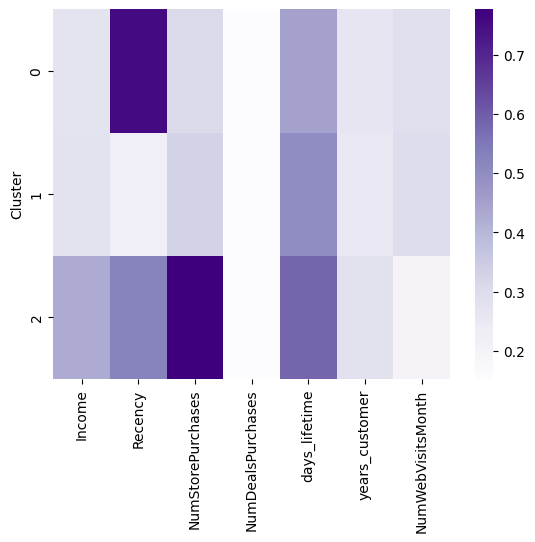

In [23]:
# Припустимо, у вас є DataFrame df з даними і мітками кластерів labels
X_sc['Cluster'] = labels_sc  # Додаємо мітки кластерів до DataFrame

# Обчислюємо середні значення для кожного кластеру
cluster_means = X_sc.groupby('Cluster').mean()
sns.heatmap(cluster_means, cmap="Purples");

In [135]:
# Додаємо колонки
df_tsne['Income'] = X_sc['Income']
df_tsne['NumStorePurchases'] = X_sc['NumStorePurchases']
df_tsne['Recency'] = X_sc['Recency']
df_tsne['days_lifetime'] = X_sc['days_lifetime']

In [140]:
#Візуалізація
color_sequence = ['green', 'orange', 'purple']
fig = px.scatter(df_tsne, x='Component 1', y='Component 2', color="Cluster",
                 size='Recency', hover_data=['NumStorePurchases'])

fig.show()

**Інтерпритація кластеризації даних:**
Кластери не є чітко вираженими графічно.

Кластер 0 (синій):. Його ознаками є:
- високий рівень покупок в фізичних магазинах;
- мають середній серед клієнтів річний дохід;
- та середній рівень рівень щодо давності останньої покупки

Кластер 1 (червоний). Його ознаками є:
- високий рівень (майже 1) середнього 'Recency';
- мало покупок в фізичних магазинах
- та низький річний дохід

Кластер 2 (жовтий). його ознаками є:
- клієнти які давно щось купували у цього продавця;
- мають низькій річний дохід;
- дуже рідко, купували в фізичному магазині